# This explores the SAM model for building load profiles integrating solar and storage

1) Use the SAM model to specify my own solar and storage
2) Then...

In [1]:
scenario = "scenario-baseline"
housing_type = "single-family-detached"

In [2]:
import PySAM.Pvwattsv8 as pvwatts  # https://nrel-pysam.readthedocs.io/en/main/modules/Pvwattsv8.html
import PySAM.Battery as battery_model  # https://nrel-pysam.readthedocs.io/en/main/modules/Battery.html
import PySAM.ResourceTools as tools
import pandas as pd

years_of_analysis = 1 # Note I need ONLY ONE to ensure that I get back an 8760 load profile

### SOLAR ###
solar = pvwatts.default("PVWattsResidential")
weather_file = "alameda/weather/alameda_weather_data.csv"
solar_resource_data = tools.SAM_CSV_to_solar_data(weather_file)
solar.SolarResource.solar_resource_data = solar_resource_data

solar.SystemDesign.system_capacity = 5  # 5 kW PV system
solar.SystemDesign.dc_ac_ratio = 1.2
solar.SystemDesign.tilt = 20  # Tilt angle in degrees
solar.SystemDesign.azimuth = 180  # South facing
solar.Lifetime.dc_degradation = [0.5] * years_of_analysis  # Annual degradation rate (0.5%)


In [3]:
### STORAGE ###
battery = battery_model.from_existing(solar, "GenericBatteryResidential")

# Load the household load profile
load_data = pd.read_csv(f"alameda/{scenario}/{housing_type}/step2_county_average_electricity_loads.csv")
print(load_data.columns)  # Check available columns - I aggregated load into total_load

load_column_name = 'total_load'
load_profile = load_data[load_column_name].tolist()
battery.Load.load = load_profile

# Battery chemistry and capacity setup (Tesla Powerwall-like)
battery.BatteryCell.batt_chem = 1  # Li-ion battery chemistry
battery.BatteryCell.batt_Vnom_default = 3.6  # Default nominal voltage of battery cells [V]
battery.BatteryCell.batt_Qfull = 13.5 * 1000 / 3.6  # Full charge capacity [Ah]

# Set battery interconnection
battery.BatterySystem.batt_ac_or_dc = 1  # 1=AC-connected
battery.BatterySystem.batt_meter_position = 0  # 0=Behind the meter

# Maximum charge and discharge power [kWac]
battery.BatterySystem.batt_power_discharge_max_kwac = 5  # Max discharge power in kWac
battery.BatterySystem.batt_power_charge_max_kwac = 5  # Max charge power in kWac

# Efficiencies [%]
battery.BatterySystem.batt_ac_dc_efficiency = 96  # AC to DC efficiency (%)
battery.BatterySystem.batt_dc_ac_efficiency = 96  # DC to AC efficiency (%)

# Set the battery dispatch strategy to Peak Shaving - look ahead
battery.BatteryDispatch.batt_dispatch_choice = 0  # 0=Peak Shaving

# Battery dispatch settings
battery.BatteryDispatch.batt_dispatch_auto_can_charge = 1  # Allow charging from system
battery.BatteryDispatch.batt_dispatch_auto_can_gridcharge = 0  # Prevent grid charging
battery.BatteryDispatch.batt_dispatch_auto_can_clipcharge = 1  # Allow charging from PV clipping
battery.BatteryDispatch.batt_dispatch_discharge_only_load_exceeds_system = 0  # Discharge regardless of load vs. system

# Lifetime settings
battery.Lifetime.system_use_lifetime_output = 1
battery.Lifetime.analysis_period = years_of_analysis  # Years of analysis


Index(['timestamp', 'out.electricity.heating.energy_consumption',
       'out.electricity.heating_fans_pumps.energy_consumption',
       'out.electricity.heating_hp_bkup.energy_consumption',
       'out.electricity.cooling.energy_consumption',
       'out.electricity.cooling_fans_pumps.energy_consumption',
       'out.electricity.range_oven.energy_consumption',
       'out.electricity.hot_water.energy_consumption',
       'out.electricity.ceiling_fan.energy_consumption',
       'out.electricity.clothes_dryer.energy_consumption',
       'out.electricity.clothes_washer.energy_consumption',
       'out.electricity.dishwasher.energy_consumption',
       'out.electricity.lighting_exterior.energy_consumption',
       'out.electricity.lighting_garage.energy_consumption',
       'out.electricity.lighting_interior.energy_consumption',
       'out.electricity.mech_vent.energy_consumption',
       'out.electricity.refrigerator.energy_consumption', 'total_load'],
      dtype='object')


In [4]:
solar.execute(0)
battery.execute(0)

solar_output = solar.Outputs
battery_output = battery.Outputs

# print("Solar Output (kW):", solar_output.ac)
print("Battery Power Output (kW):", battery_output)

Battery Power Output (kW): <Battery.Outputs object at 0x132422e50>


# Identify solar, storage, and net load
Plot for one day of the year

Maximum difference between load profile and total supply: 1.3877787807814457e-17
The total supply matches the load profile.


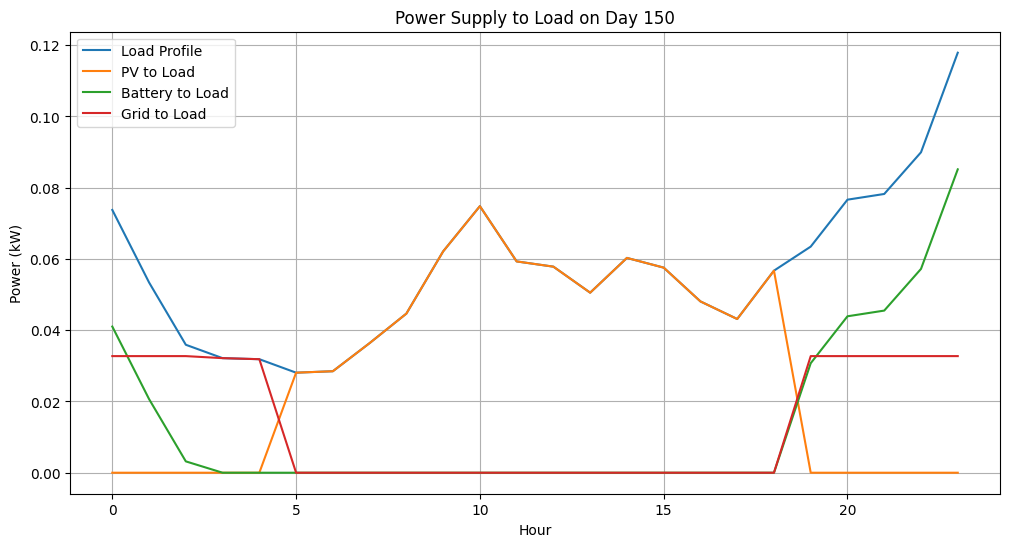

In [5]:
system_to_load = battery_output.system_to_load  # Electricity to load from system AC [kW]
batt_to_load = battery_output.batt_to_load  # Electricity to load from battery AC [kW]
grid_to_load = battery_output.grid_to_load  # Electricity to load from grid AC [kW]

# Calculate the total supply to the load from solar and battery
solar_battery_to_load = [s + b for s, b in zip(system_to_load, batt_to_load)]

# Calculate the residual load that needs to be met by the grid
grid_import = grid_to_load # "net load"

# Verify that the total supply matches the load profile
total_supply = [s + b + g for s, b, g in zip(system_to_load, batt_to_load, grid_to_load)]
difference = [l - t for l, t in zip(load_profile, total_supply)]
max_difference = max(abs(d) for d in difference)
print(f"Maximum difference between load profile and total supply: {max_difference}")

# Ensure that the max difference is within acceptable bounds (should be zero or very close)
if max_difference > 1e-6:
    print("Warning: There is a discrepancy between the load profile and the total supply.")
else:
    print("The total supply matches the load profile.")

# Plot the results for a day
import matplotlib.pyplot as plt

day = 150  # Choose the 150th day of the year to plot to see one example
start = day * 24
end = start + 24

plt.figure(figsize=(12, 6))
plt.plot(range(24), load_profile[start:end], label='Load Profile')
plt.plot(range(24), system_to_load[start:end], label='PV to Load')
plt.plot(range(24), batt_to_load[start:end], label='Battery to Load')
plt.plot(range(24), grid_to_load[start:end], label='Grid to Load')
plt.xlabel('Hour')
plt.ylabel('Power (kW)')
plt.title('Power Supply to Load on Day {}'.format(day))
plt.legend()
plt.grid(True)
plt.show()

# Check that all lengths match
Lengths might not match if I've run the time period of evaluation for more than 1 year, since the NREL load profile is limited to just 1 year

Exclude the NREL load profile if this is the case

In [6]:
# Check lengths of all relevant variables
print(f"Length of load_profile: {len(load_profile)}")
print(f"Length of system_to_load: {len(system_to_load)}")
print(f"Length of batt_to_load: {len(batt_to_load)}")
print(f"Length of grid_to_load: {len(grid_to_load)}")
print(f"Length of solar_battery_to_load: {len(solar_battery_to_load)}")
print(f"Length of grid_import: {len(grid_import)}")
print(f"Length of total_supply: {len(total_supply)}")
print(f"Length of difference: {len(difference)}")

Length of load_profile: 8760
Length of system_to_load: 8760
Length of batt_to_load: 8760
Length of grid_to_load: 8760
Length of solar_battery_to_load: 8760
Length of grid_import: 8760
Length of total_supply: 8760
Length of difference: 8760


# Save to CSV

In [7]:
# Create a datetime index for each hour of the year
# Year corresponds to NREL input load profile
date_range = pd.date_range(start='2018-01-01', periods=8760, freq='H') 

# Create the DataFrame
df = pd.DataFrame({
    'Load Profile': load_profile,
    'System to Load': system_to_load,
    'Battery to Load': batt_to_load,
    'Grid to Load': grid_to_load,
    'Solar + Battery to Load': solar_battery_to_load,
    'Grid Import': grid_import,
    'Total Supply': total_supply,
    'Difference': difference
}, index=date_range)


df.head()
# Optional: Reset index if you prefer to have the datetime as a column
df.reset_index(inplace=True)
df.rename(columns={'index': 'Datetime'}, inplace=True)

# Save the DataFrame to a single CSV file with datetime index
df.to_csv(f"alameda/{scenario}/{housing_type}/step3_sam_optimized_load_profiles.csv")

In [8]:
df.head()

,Datetime,Load Profile,System to Load,Battery to Load,Grid to Load,Solar + Battery to Load,Grid Import,Total Supply,Difference
0,2018-01-01 00:00:00,0.101285,0.0,0.068600,0.032686,0.068600,0.032686,0.101285,0.0
1,2018-01-01 01:00:00,0.090485,0.0,0.057800,0.032686,0.057800,0.032686,0.090485,0.0
2,2018-01-01 02:00:00,0.059479,0.0,0.026793,0.032685,0.026793,0.032685,0.059479,0.0
3,2018-01-01 03:00:00,0.033882,0.0,0.000000,0.033882,0.000000,0.033882,0.033882,0.0
4,2018-01-01 04:00:00,0.032685,0.0,0.000000,0.032685,0.000000,0.032685,0.032685,0.0
